# Improve ConvClassifier With Pre-trained Word2Vec Model

**Group members**: Linghao ZENG, Zhe HUANG

We use one **single** notebook to implement Word2Vec and ConvClassifier. The models with different hyperparameters were saved locally and loaded by the ConvClassifier on experimental purpose.

In [ ]:
%%capture
!pip install transformers datasets

In [ ]:
import random
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import math
from torch.utils.data import DataLoader, Dataset
from tabulate import tabulate
from datasets import load_dataset

from tqdm.notebook import tqdm
from transformers import BertTokenizer

# Data loading


In [ ]:
dataset = load_dataset("scikit-learn/imdb", split="train")
print(dataset)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['review', 'sentiment'],
    num_rows: 50000
})


# Data Preprocessing

1. The first cells of the notebook are the same as in the TP on text convolution.  
Apply the same preprocessing to get a dataset (with the same tokenizer) with a `train` and a `validation` split, with two columns `review_ids` (list of int) and `label` (int).

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)
vocab_size = len(tokenizer.vocab)
print(vocab_size)


30522


In [ ]:
def preprocessing_fn(x, tokenizer):
    x["review_ids"] = tokenizer(
        x["review"],
        add_special_tokens=False,
        truncation=True,
        max_length=256,
        padding=False,
        return_attention_mask=False,
    )["input_ids"]
    x["label"] = 0 if x["sentiment"] == "negative" else 1
    return x


In [ ]:
n_samples = 5000  # the number of training example

# We first shuffle the data !
shuffled_dataset = dataset.shuffle(seed=42)

# Select 5000 samples
dataset_5000_samples = shuffled_dataset.select(range(n_samples))

# Tokenize the dataset
tokenized_dataset = dataset_5000_samples.map(preprocessing_fn, fn_kwargs={'tokenizer': tokenizer})

# Remove useless columns
tokenized_dataset = tokenized_dataset.map(remove_columns=['review', 'sentiment'])

# Split the train and test
split_data = tokenized_dataset.train_test_split(test_size=0.2)

document_train_set = split_data["train"]
document_valid_set = split_data["test"]


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

2. Write a function `extract_words_contexts`. It should retrieve all pairs of valid ($w$, $C^+$) from a list of ids representing a text document. It takes the radius $R$ as an argument. Its output is therefore two lists:  
• The first one contains the ids of $w$.  
• The second one contains the list of ids of $C^+$, within the local window, corresponding to $w$.  
Make sure that every $C^+$ has the same size (i.e., contains the same number of ids). Explain clearly how you handle the borders (every strategy can be valid, as as long as it is justified).

In [ ]:
def extract_words_contexts(input_ids, radius):
    """
    We pad the context window with <PAD> (which is 0) tokens on the
    left and right if the central word is near the document's boundaries.
    """
    central_words = []  # IDs of central words (w)
    context_words_lists = []  # Lists of IDs of context words (C+)

    for i, word_id in enumerate(input_ids):
        context_words = []

        # Define the left and right bounds of the context window
        left_bound = max(0, i - radius)
        right_bound = min(len(input_ids), i + radius + 1)

        # Handle the left boundary
        if i - radius < 0:
            left_padding = [0] * (radius - i)  # Padding with <PAD> tokens
            context_words.extend(left_padding)

        # Collect context words within the local window
        for j in range(left_bound, right_bound):
            if j != i:  # Skip the central word itself
                context_words.append(input_ids[j])

        # Handle the right boundary
        if i + radius >= len(input_ids):
            right_padding = [0] * (i + radius - len(input_ids) + 1)  # Padding with <PAD> tokens
            context_words.extend(right_padding)

        # Append central word and its corresponding context words
        central_words.append(word_id)
        context_words_lists.append(context_words)

    return central_words, context_words_lists



In [ ]:
# Example
input_ids = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
radius = 3
central_words, context_words_lists = extract_words_contexts(input_ids, radius)

display(central_words, context_words_lists)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

[[0, 0, 0, 1, 2, 3],
 [0, 0, 0, 2, 3, 4],
 [0, 0, 1, 3, 4, 5],
 [0, 1, 2, 4, 5, 6],
 [1, 2, 3, 5, 6, 7],
 [2, 3, 4, 6, 7, 8],
 [3, 4, 5, 7, 8, 9],
 [4, 5, 6, 8, 9, 0],
 [5, 6, 7, 9, 0, 0],
 [6, 7, 8, 0, 0, 0]]

3. Write a function `flatten_dataset_to_list` that applies the function `extract_words_contexts` on a whole dataset.

In [ ]:
def flatten_dataset_to_list(dataset, radius):
    central_words_list = []  # List to store central words (w)
    context_words_list = []  # List to store context words (C+)

    for x in dataset:
        input_ids = x["review_ids"]
        central_words, context_words_lists = extract_words_contexts(input_ids, radius)

        central_words_list.extend(central_words)
        context_words_list.extend(context_words_lists)

    return central_words_list, context_words_list

4. Apply the function to your initial `document_train_set` and `document_valid_set`, and get the corresponding flattened lists.

In [ ]:
R = 2

# Apply the function to the training set
train_central_words, train_context_words = flatten_dataset_to_list(document_train_set, R)

# Apply the function to the validation set
valid_central_words, valid_context_words = flatten_dataset_to_list(document_valid_set, R)

5. Embed these lists in two valid PyTorch `Dataset`, like in HW 1, call them `train_set` and `valid_set`.

In [ ]:
class MyDataset(Dataset):
    def __init__(self, central_words, context_words):
        self.central_words = central_words
        self.context_words = context_words

    def __len__(self):
        return len(self.central_words)

    def __getitem__(self, idx):
        return {
                "central_word": self.central_words[idx],
                "context_words": self.context_words[idx]
               }

# Create train_set and valid_set using the flattened lists
train_set = MyDataset(train_central_words, train_context_words)
valid_set = MyDataset(valid_central_words, valid_context_words)

6. Write a `collate_fn` function that adds the negative context to the batch. It should be parametrized by the scaling factor `K`. The output of `collate_fn` should be a Python dictionary, with three keys:  
• `word_id`,  
• `positive_context_ids`,  
• `negative_context_ids`.  
Make sure that each value of the dictionary is a valid `torch.Tensor`.

In [ ]:
def collate_fn(batch, vocab_size, K):
    word_ids = []
    positive_context_ids = []
    negative_context_ids = []

    # Iterate through the batch to extract word and context IDs
    for item in batch:
        word_id = item["central_word"]
        context_ids = item["context_words"]

        # Randomly sample 2KR negative context words
        sampled_negative_context = random.sample(range(vocab_size), len(context_ids)*K)

        # Append word and context IDs to the respective lists
        word_ids.append(word_id)
        positive_context_ids.append(context_ids)
        negative_context_ids.append(sampled_negative_context)

    return {
        'word_id': torch.tensor(word_ids),
        'positive_context_ids': torch.tensor(positive_context_ids),
        'negative_context_ids': torch.tensor(negative_context_ids)
    }


7. Wraps everything in a `DataLoader`, like in HW 1.

In [ ]:
K = 10

# Create DataLoader for the training dataset
train_batch_size = 32
train_dataloader = DataLoader(
    train_set,
    batch_size=train_batch_size,
    shuffle=True,  # Shuffle the data during training
    collate_fn=lambda batch: collate_fn(batch, vocab_size, K)
)

# Create DataLoader for the validation dataset
valid_batch_size = 32
valid_dataloader = DataLoader(
    valid_set,
    batch_size=valid_batch_size,
    shuffle=False,  # No need to shuffle for validation
    collate_fn=lambda batch: collate_fn(batch, vocab_size, K)
)


8. Make 2 or 3 three iterations in the `DataLoader` and print $R$, $K$ and the
shapes of all the tensors in the batches (let the output be visible).

In [ ]:
# Create an iterator for the DataLoader
train_loader_iter = iter(train_dataloader)
valid_loader_iter = iter(valid_dataloader)

def process_batch(batch, iteration, batch_size, R, K):
    word_id = batch['word_id']
    positive_context_ids = batch['positive_context_ids']
    negative_context_ids = batch['negative_context_ids']
    print(f"Iteration {iteration} - Batch size: {batch_size}, R: {R}, K: {K}")
    print(f"Input IDs shape: {word_id.shape}")
    print(f"Positive Context IDs shape: {positive_context_ids.shape}")
    print(f"Negative Context IDs shape: {negative_context_ids.shape}")
    print("--------------------------------------------------")

# Process and print information for the first 2 batches
for i in range(1, 3):
    batch = next(train_loader_iter)
    print("Train dataloader:")
    process_batch(batch, i, train_batch_size, R, K)
    batch = next(valid_loader_iter)
    print("Valid dataloader:")
    process_batch(batch, i, valid_batch_size, R, K)


Train dataloader:
Iteration 1 - Batch size: 32, R: 2, K: 10
Input IDs shape: torch.Size([32])
Positive Context IDs shape: torch.Size([32, 4])
Negative Context IDs shape: torch.Size([32, 40])
--------------------------------------------------
Valid dataloader:
Iteration 1 - Batch size: 32, R: 2, K: 10
Input IDs shape: torch.Size([32])
Positive Context IDs shape: torch.Size([32, 4])
Negative Context IDs shape: torch.Size([32, 40])
--------------------------------------------------
Train dataloader:
Iteration 2 - Batch size: 32, R: 2, K: 10
Input IDs shape: torch.Size([32])
Positive Context IDs shape: torch.Size([32, 4])
Negative Context IDs shape: torch.Size([32, 40])
--------------------------------------------------
Valid dataloader:
Iteration 2 - Batch size: 32, R: 2, K: 10
Input IDs shape: torch.Size([32])
Positive Context IDs shape: torch.Size([32, 4])
Negative Context IDs shape: torch.Size([32, 40])
--------------------------------------------------


## Model

9. Write a model named `Word2Vec` which is a valid `torch.nn.Module` (i.e., write a class that inherits from the `torch.nn.Module`), and implement the `Word2Vec` model. It should be parametrized by the vocabulary size and the embeddings dimension. Use the module `torch.nn.Embedding`.

In [ ]:
class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embed_size):
        super(Word2Vec, self).__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size

        # Embedding for words
        self.word_embeddings = nn.Embedding(vocab_size, embed_size)

        # Embedding for positive and negative context words
        self.context_embeddings = nn.Embedding(vocab_size, embed_size)

    def forward(self, word_id, positive_context_ids, negative_context_ids):
        # Embed the word
        word_embed = self.word_embeddings(word_id)

        # Embed the positive context words
        positive_context_embed = self.context_embeddings(positive_context_ids)

        # Embed the negative context words
        negative_context_embed = self.context_embeddings(negative_context_ids)

        return word_embed, positive_context_embed, negative_context_embed


In [ ]:
embedding_dim = 100
model = Word2Vec(vocab_size, embedding_dim)

In [ ]:
class Word2VecLoss(nn.Module):
    def __init__(self):
        super(Word2VecLoss, self).__init__()

    def forward(self, word_embed, positive_context_embed, negative_context_embed):
        word_embed = word_embed.unsqueeze(1)
        # Compute the similarity score for positive context words
        positive_similarity = torch.sigmoid(torch.sum(word_embed * positive_context_embed, dim=2))

        # Compute the similarity score for negative context words
        negative_similarity = torch.sigmoid(torch.sum(word_embed * negative_context_embed, dim=2))

        # Compute the loss for positive and negative contexts separately
        positive_loss = -torch.log(positive_similarity + 1e-10)
        negative_loss = -torch.log(1 - negative_similarity + 1e-10)

        # Sum the losses for both positive and negative contexts
        total_loss = positive_loss.mean() + negative_loss.mean()

        return total_loss


10. Train the model. The training should be parametrized by the batch size `B`, and the number of epochs `E`.

In [ ]:
def training_word2vec(model, B, E, train_dataloader, vocab_size, lr=1e-3):
    """
    B: batch size
    E: number of epochs
    train_dataloader: DataLoader for the Word2Vec dataset
    vocab_size: Size of the vocabulary
    K: Number of negative examples to sample
    lr: learning rate
    """
    # Move model to GPU if CUDA is available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=lr
    )

    criterion = Word2VecLoss()

    for e in range(E):
        # Set model to training mode
        model.train()

        # Tracking variables
        total_loss = 0

        # Wrap the dataloader with tqdm
        pbar = tqdm(train_dataloader, desc=f"Epoch {e + 1}/{E}")

        for batch in pbar:
            word_id, positive_context_ids, negative_context_ids = (
                batch["word_id"].to(device),
                batch["positive_context_ids"].to(device),
                batch["negative_context_ids"].to(device),
            )

            optimizer.zero_grad()


            word_embed, positive_context_embed, negative_context_embed = model(
                word_id, positive_context_ids, negative_context_ids
            )

            loss = criterion(word_embed, positive_context_embed, negative_context_embed)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Update the progress bar description with the current loss
            pbar.set_description(f"Epoch {e + 1}/{E}, Loss: {loss.item():.4f}")

        avg_loss = total_loss / len(train_dataloader)
        print(f"Epoch {e + 1}/{E}, Average Loss: {avg_loss:.4f}")

In [ ]:
E = 3 # Number of epochs
training_word2vec(model, train_batch_size, E, train_dataloader, vocab_size, 1e-3)

Epoch 1/3:   0%|          | 0/25740 [00:00<?, ?it/s]

Epoch 1/3, Average Loss: 2.7558


Epoch 2/3:   0%|          | 0/25740 [00:00<?, ?it/s]

Epoch 2/3, Average Loss: 0.9541


Epoch 3/3:   0%|          | 0/25740 [00:00<?, ?it/s]

Epoch 3/3, Average Loss: 0.6688


11. Validates it's accuracy on the test set.

In [ ]:
def validate_word2vec(model, valid_dataloader):
    criterion = Word2VecLoss()
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    with torch.no_grad():  # Disable gradient computation
        pbar = tqdm(valid_dataloader, desc="Validating")
        for batch in pbar:
            word_id, positive_context_ids, negative_context_ids = (
                batch["word_id"],
                batch["positive_context_ids"],
                batch["negative_context_ids"],
            )

            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            word_id, positive_context_ids, negative_context_ids = word_id.to(device), positive_context_ids.to(device), negative_context_ids.to(device)

            word_embed, positive_context_embed, negative_context_embed = model(
                word_id, positive_context_ids, negative_context_ids
            )

            loss = criterion(word_embed, positive_context_embed, negative_context_embed)
            total_loss += loss.item()
            pbar.set_description(f"Validating, Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(valid_dataloader)
    print(f'Validation Loss: {avg_loss:.4f}')

In [ ]:
validate_word2vec(model, valid_dataloader)

Validating:   0%|          | 0/6485 [00:00<?, ?it/s]

Validation Loss: 0.8592


12. Write a function `save_model` that saves the model's embeddings in a file. The file name should be formated like:
`"model_dim_<d>_radius-<R>_ratio-<K>-batch-<B>-epoch-<E>.ckpt"`

In [ ]:
def save_model(model, d, R, K, B, E):
    file_name = f"model_dim-{d}_radius-{R}_ratio-{K}_batch-{B}_epoch-{E}.ckpt"
    torch.save(model.state_dict(), file_name)
    print(f'Model saved to {file_name}')

    return file_name

# Save the model
save_model(model, embedding_dim, R, K, train_batch_size, E)

Model saved to model_dim-100_radius-2_ratio-10_batch-32_epoch-3.ckpt


'model_dim-100_radius-2_ratio-10_batch-32_epoch-3.ckpt'

13. Once you have a working code, you can launch a bigger training, using
more documents, if it does not take too much time.

In [ ]:
E = 10 # Number of epochs
lr = 1e-3
embedding_dim = 100

model = Word2Vec(vocab_size, embedding_dim)
training_word2vec(model, train_batch_size, E, train_dataloader, vocab_size, lr)
validate_word2vec(model, valid_dataloader)
save_model(model, embedding_dim, R, K, train_batch_size, E)

Epoch 1/10:   0%|          | 0/25740 [00:00<?, ?it/s]

Epoch 1/10, Average Loss: 2.7605


Epoch 2/10:   0%|          | 0/25740 [00:00<?, ?it/s]

Epoch 2/10, Average Loss: 0.9569


Epoch 3/10:   0%|          | 0/25740 [00:00<?, ?it/s]

Epoch 3/10, Average Loss: 0.6684


Epoch 4/10:   0%|          | 0/25740 [00:00<?, ?it/s]

Epoch 4/10, Average Loss: 0.5399


Epoch 5/10:   0%|          | 0/25740 [00:00<?, ?it/s]

Epoch 5/10, Average Loss: 0.4638


Epoch 6/10:   0%|          | 0/25740 [00:00<?, ?it/s]

Epoch 6/10, Average Loss: 0.4151


Epoch 7/10:   0%|          | 0/25740 [00:00<?, ?it/s]

Epoch 7/10, Average Loss: 0.3814


Epoch 8/10:   0%|          | 0/25740 [00:00<?, ?it/s]

Epoch 8/10, Average Loss: 0.3584


Epoch 9/10:   0%|          | 0/25740 [00:00<?, ?it/s]

Epoch 9/10, Average Loss: 0.3414


Epoch 10/10:   0%|          | 0/25740 [00:00<?, ?it/s]

Epoch 10/10, Average Loss: 0.3293


Validating:   0%|          | 0/6485 [00:00<?, ?it/s]

Validation Loss: 0.8200
Model saved to model_dim-100_radius-2_ratio-10_batch-32_epoch-10.ckpt


'model_dim-100_radius-2_ratio-10_batch-32_epoch-10.ckpt'

## Classification task

1. Write a function `load_model` that takes a path to a saved Word2Vec embeddings (with the previous formatting) and loads the checkpoint the embeddings directly to the `ConvolutionModel` (you can use either the state-of-the art model or the first small model).

In [ ]:
class Conv1dClassifier(nn.Module):
    """A text classifier:
    - input = minibatch
    - output = probability associated to a binary classification task
    - vocab_size: the number of words in the vocabulary we want to embed
    - embedding_dim: size of the word vectors
    """

    def __init__(self, vocab_size, embedding_dim, feature_size=100, kernel_size=3):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.feature_size = feature_size
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        self.conv = nn.Conv1d(in_channels=embedding_dim, out_channels=feature_size, kernel_size=kernel_size, padding=1)
        self.linear = nn.Linear(feature_size, 1)
        self.dropout = nn.Dropout(0.5)


    def forward(self, input_ids):
        emb = self.embedding(input_ids)
        conv_output = self.conv(emb.view(-1, emb.size(2), emb.size(1)))
        pool_output = F.max_pool1d(conv_output, kernel_size=conv_output.size(2))
        flat_output = pool_output.view(pool_output.size(0), -1)
        dropped_output = self.dropout(flat_output)
        linear_output = self.linear(dropped_output)
        output = F.sigmoid(linear_output)
        return output

In [ ]:
def load_model(file_path, conv1d_classifier, embed_dim):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # Load the state dictionary from the specified file
    word2vec_state_dict = torch.load(file_path, map_location=torch.device(device))

    # Create a new Word2Vec model and load the state dictionary
    # Assuming vocab_size and embed_dim are known, adjust as necessary
    word2vec_model = Word2Vec(vocab_size, embed_dim)
    word2vec_model.load_state_dict(word2vec_state_dict)

    # Transfer the embeddings from the Word2Vec model to the Conv1dClassifier
    # No gradient computations are needed for this operation
    with torch.no_grad():
        conv1d_classifier.embedding.weight.data = word2vec_model.word_embeddings.weight.data

2. Train the model, initialized with these embeddings.

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
class DataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, batch):
        features = [{"input_ids": x["review_ids"]} for x in batch]
        features = self.tokenizer.pad(
            features, padding="max_length", max_length=256, return_tensors="pt"
        )
        label = torch.tensor([x["label"] for x in batch])[:, None]
        return {"review_ids": features["input_ids"], "label": label}

data_collator = DataCollator(tokenizer)


# Define the DataLoader
batch_size = 32
train_dataloader = DataLoader(
    document_train_set, batch_size=batch_size, collate_fn=data_collator
)
valid_dataloader = DataLoader(
    document_valid_set, batch_size=batch_size, collate_fn=data_collator
)

In [ ]:
# Initialize with embeddings
embed_dim = 100
file_path = '/content/model_dim-100_radius-2_ratio-10_batch-32_epoch-10.ckpt'
conv1d_classifier_emb = Conv1dClassifier(vocab_size=vocab_size, embedding_dim=embed_dim)
load_model(file_path, conv1d_classifier_emb, embed_dim)

## Define the training loss
loss_function = nn.BCELoss()
## The optimizer
optimizer = torch.optim.Adam(conv1d_classifier_emb.parameters(), lr=0.001)


# Lists to store results
training_losses_with_embeddings = []
validation_losses_with_embeddings = []
training_accuracies_with_embeddings = []
validation_accuracies_with_embeddings = []

n_epochs = 10 # the number of training epochs
for e in range(n_epochs):
    # Training
    conv1d_classifier_emb.train()  # set the model to training mode, affecting dropout layer behavior
    total_loss = 0
    train_predictions, train_labels = [], []
    for batch in train_dataloader:
        optimizer.zero_grad()  # clear gradients
        input_ids, labels = batch['review_ids'], batch['label']
        predictions = conv1d_classifier_emb(input_ids)
        loss = loss_function(predictions, labels.float())
        loss.backward()  # calculate gradients
        optimizer.step()  # update weights
        total_loss += loss.item()

        # Collect predictions and labels for accuracy calculation
        train_predictions.extend(predictions.squeeze().cpu().detach().numpy())
        train_labels.extend(labels.cpu().numpy())

    # Validation
    conv1d_classifier_emb.eval()  # set the model to eval mode
    val_loss = 0
    val_predictions, val_labels = [], []
    with torch.no_grad():  # disable gradient calculation during validation
        for batch in valid_dataloader:
            input_ids, labels = batch['review_ids'], batch['label']
            predictions = conv1d_classifier_emb(input_ids)
            loss = loss_function(predictions, labels.float())
            val_loss += loss.item()

            # Collect predictions and labels for accuracy calculation
            val_predictions.extend(predictions.squeeze().cpu().detach().numpy())
            val_labels.extend(labels.cpu().numpy())

    train_accuracy = accuracy_score(train_labels, [1 if p >= 0.5 else 0 for p in train_predictions])
    training_losses_with_embeddings.append(total_loss / len(train_dataloader))
    training_accuracies_with_embeddings.append(train_accuracy)

    val_accuracy = accuracy_score(val_labels, [1 if p >= 0.5 else 0 for p in val_predictions])
    validation_losses_with_embeddings.append(val_loss / len(valid_dataloader))
    validation_accuracies_with_embeddings.append(val_accuracy)

    print(f'Epoch {e}, Training loss: {total_loss/len(train_dataloader)}, Validation loss: {val_loss/len(valid_dataloader)}, Training accuracy: {train_accuracy:.4f}, Validation accuracy: {val_accuracy:.4f}')

Epoch 0, Training loss: 0.723469847202301, Validation loss: 0.6956710107624531, Training accuracy: 0.5010, Validation accuracy: 0.5190
Epoch 1, Training loss: 0.6973862385749817, Validation loss: 0.6942985225468874, Training accuracy: 0.5450, Validation accuracy: 0.5230
Epoch 2, Training loss: 0.6839257192611694, Validation loss: 0.6937631946057081, Training accuracy: 0.5613, Validation accuracy: 0.5240
Epoch 3, Training loss: 0.6687597217559814, Validation loss: 0.6958806961774826, Training accuracy: 0.5910, Validation accuracy: 0.5250
Epoch 4, Training loss: 0.6605015845298767, Validation loss: 0.6955422945320606, Training accuracy: 0.6070, Validation accuracy: 0.5200
Epoch 5, Training loss: 0.6510602493286133, Validation loss: 0.693512050434947, Training accuracy: 0.6250, Validation accuracy: 0.5230
Epoch 6, Training loss: 0.638145504951477, Validation loss: 0.692372215911746, Training accuracy: 0.6475, Validation accuracy: 0.5300
Epoch 7, Training loss: 0.6186829428672791, Validati

3. Compare the results with the model without this initialization.

In [ ]:
conv1d_classifier = Conv1dClassifier(vocab_size=vocab_size, embedding_dim=embed_dim)

## The optimizer
optimizer = torch.optim.Adam(conv1d_classifier.parameters(), lr=0.001)


# Lists to store results
training_losses_without_embeddings = []
validation_losses_without_embeddings = []
training_accuracies_without_embeddings = []
validation_accuracies_without_embeddings = []

n_epochs = 10 # the number of training epochs
for e in range(n_epochs):
    # Training
    conv1d_classifier.train()  # set the model to training mode, affecting dropout layer behavior
    total_loss = 0
    train_predictions, train_labels = [], []
    for batch in train_dataloader:
        optimizer.zero_grad()  # clear gradients
        input_ids, labels = batch['review_ids'], batch['label']
        predictions = conv1d_classifier(input_ids)
        loss = loss_function(predictions, labels.float())
        loss.backward()  # calculate gradients
        optimizer.step()  # update weights
        total_loss += loss.item()

        # Collect predictions and labels for accuracy calculation
        train_predictions.extend(predictions.squeeze().cpu().detach().numpy())
        train_labels.extend(labels.cpu().numpy())

    # Validation
    conv1d_classifier.eval()  # set the model to eval mode
    val_loss = 0
    val_predictions, val_labels = [], []
    with torch.no_grad():  # disable gradient calculation during validation
        for batch in valid_dataloader:
            input_ids, labels = batch['review_ids'], batch['label']
            predictions = conv1d_classifier(input_ids)
            loss = loss_function(predictions, labels.float())
            val_loss += loss.item()
            # Collect predictions and labels for accuracy calculation
            val_predictions.extend(predictions.squeeze().cpu().detach().numpy())
            val_labels.extend(labels.cpu().numpy())

    train_accuracy = accuracy_score(train_labels, [1 if p >= 0.5 else 0 for p in train_predictions])
    training_losses_without_embeddings.append(total_loss / len(train_dataloader))
    training_accuracies_without_embeddings.append(train_accuracy)

    val_accuracy = accuracy_score(val_labels, [1 if p >= 0.5 else 0 for p in val_predictions])
    validation_losses_without_embeddings.append(val_loss / len(valid_dataloader))
    validation_accuracies_without_embeddings.append(val_accuracy)

    print(f'Epoch {e}, Training loss: {total_loss/len(train_dataloader)}, Validation loss: {val_loss/len(valid_dataloader)}, Training accuracy: {train_accuracy:.4f}, Validation accuracy: {val_accuracy:.4f}')

Epoch 0, Training loss: 0.7616331000328064, Validation loss: 0.6946634128689766, Training accuracy: 0.5182, Validation accuracy: 0.5170
Epoch 1, Training loss: 0.706054413318634, Validation loss: 0.6931754723191261, Training accuracy: 0.5477, Validation accuracy: 0.5130
Epoch 2, Training loss: 0.6798760147094727, Validation loss: 0.694267375394702, Training accuracy: 0.5757, Validation accuracy: 0.5160
Epoch 3, Training loss: 0.667362678527832, Validation loss: 0.6939719393849373, Training accuracy: 0.5917, Validation accuracy: 0.5150
Epoch 4, Training loss: 0.656891453742981, Validation loss: 0.6975610684603453, Training accuracy: 0.6075, Validation accuracy: 0.5230
Epoch 5, Training loss: 0.6516566772460938, Validation loss: 0.6961380913853645, Training accuracy: 0.6165, Validation accuracy: 0.5160
Epoch 6, Training loss: 0.6418726508617401, Validation loss: 0.6933469139039516, Training accuracy: 0.6242, Validation accuracy: 0.5270
Epoch 7, Training loss: 0.6288013834953308, Validati

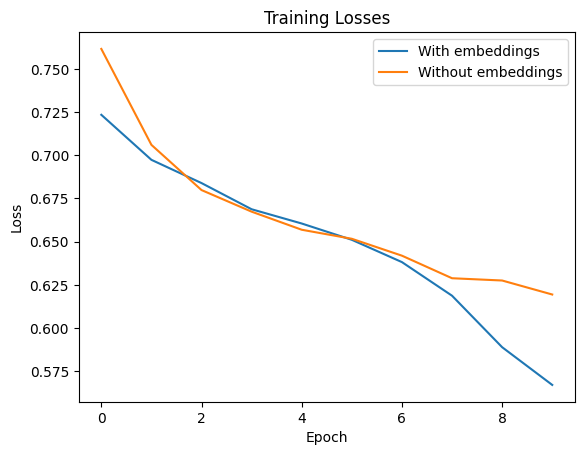

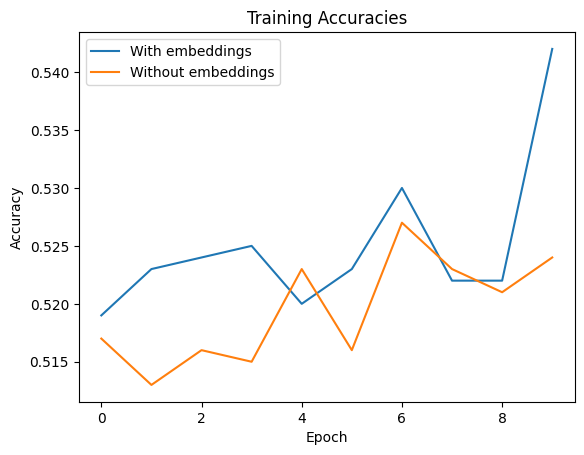

In [ ]:
# plot the differences of using Word2Vec or not
import matplotlib.pyplot as plt

# Loss
plt.figure()
plt.plot(range(len(training_losses_with_embeddings)), training_losses_with_embeddings, label="With embeddings")
plt.plot(range(len(training_losses_without_embeddings)), training_losses_without_embeddings, label="Without embeddings")
plt.legend()
plt.title("Training Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.figure()
plt.plot(range(len(validation_accuracies_with_embeddings)), validation_accuracies_with_embeddings, label="With embeddings")
plt.plot(range(len(validation_accuracies_without_embeddings)), validation_accuracies_without_embeddings, label="Without embeddings")
plt.legend()
plt.title("Training Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()


4. Make a small ablation study on the influence of some parameters of the
Word2Vec model on the classification task. Analyze the results.


In [ ]:
def ablation_study(embedding_dim, R, K):
    """
    embedding_dim: dimension of embedding layer in the Word2vec model
    R: radius of the context window
    K:  negative sampling ratio
    """
    # Apply the function to the training set and validation set
    train_central_words, train_context_words = flatten_dataset_to_list(document_train_set, R)
    valid_central_words, valid_context_words = flatten_dataset_to_list(document_valid_set, R)

    # Create train_set and valid_set using the flattened lists
    train_set = MyDataset(train_central_words, train_context_words)
    valid_set = MyDataset(valid_central_words, valid_context_words)

    # Create DataLoader for the training dataset and validation dataset
    train_batch_size = 32
    train_dataloader = DataLoader(
        train_set,
        batch_size=train_batch_size,
        shuffle=True,  # Shuffle the data during training
        collate_fn=lambda batch: collate_fn(batch, vocab_size, K)
    )
    valid_dataloader = DataLoader(
        valid_set,
        batch_size=32,
        shuffle=False,  # No need to shuffle for validation
        collate_fn=lambda batch: collate_fn(batch, vocab_size, K)
    )

    # Train and save the Word2Vec model
    model = Word2Vec(vocab_size, embedding_dim)
    training_word2vec(model, train_batch_size, 10, train_dataloader, vocab_size, 1e-3)
    file_path = save_model(model, embedding_dim, R, K, train_batch_size, E)


    ###################################################################################################


    # Use the pre-trained Word2Vec model in our classification
    file_path = '/content/' + f"model_dim-{embedding_dim}_radius-{R}_ratio-{K}_batch-32_epoch-10.ckpt"
    conv1d_classifier_emb = Conv1dClassifier(vocab_size=vocab_size, embedding_dim=embed_dim)
    load_model(file_path, conv1d_classifier_emb, embedding_dim)

    # Define the DataLoader
    batch_size = 32
    train_dataloader = DataLoader(
        document_train_set, batch_size=batch_size, collate_fn=data_collator
    )
    valid_dataloader = DataLoader(
        document_valid_set, batch_size=batch_size, collate_fn=data_collator
    )

    # Lists to store results
    training_losses = []
    validation_losses = []
    training_accuracies = []
    validation_accuracies = []

    # Training of the classification model
    n_epochs = 10 # the number of training epochs
    for e in range(n_epochs):
        # Training
        conv1d_classifier_emb.train()  # set the model to training mode, affecting dropout layer behavior
        total_loss = 0
        train_predictions, train_labels = [], []
        for batch in train_dataloader:
            optimizer.zero_grad()  # clear gradients
            input_ids, labels = batch['review_ids'], batch['label']
            predictions = conv1d_classifier_emb(input_ids)
            loss = loss_function(predictions, labels.float())
            loss.backward()  # calculate gradients
            optimizer.step()  # update weights
            total_loss += loss.item()

            # Collect predictions and labels for accuracy calculation
            train_predictions.extend(predictions.squeeze().cpu().detach().numpy())
            train_labels.extend(labels.cpu().numpy())
        # Calculate accuracy
        train_accuracy = accuracy_score(train_labels, [1 if p >= 0.5 else 0 for p in train_predictions])
        training_losses.append(total_loss / len(train_dataloader))
        training_accuracies.append(train_accuracy)

        # Validation
        conv1d_classifier_emb.eval()  # set the model to eval mode
        val_loss = 0
        val_predictions, val_labels = [], []
        with torch.no_grad():  # disable gradient calculation during validation
            for batch in valid_dataloader:
                input_ids, labels = batch['review_ids'], batch['label']
                predictions = conv1d_classifier_emb(input_ids)
                loss = loss_function(predictions, labels.float())
                val_loss += loss.item()

                # Collect predictions and labels for accuracy calculation
                val_predictions.extend(predictions.squeeze().cpu().detach().numpy())
                val_labels.extend(labels.cpu().numpy())
        # Calculate accuracy
        val_accuracy = accuracy_score(val_labels, [1 if p >= 0.5 else 0 for p in val_predictions])
        validation_losses.append(val_loss / len(valid_dataloader))
        validation_accuracies.append(val_accuracy)

    return {
        "embedding_dim": embedding_dim,
        "R": R,
        "K": K,
        "training_losses": training_losses,
        "validation_losses": validation_losses,
        "training_accuracies": training_accuracies,
        "validation_accuracies": validation_accuracies,
    }

In [ ]:
# Define a function to run an ablation study with different parameters
def run_ablation_study(embedding_dims, radius, negative_sampling_ratios):
    for embedding_dim in embedding_dims:
        for R in radius:
            for K in negative_sampling_ratios:
                print(f"Ablation study for embedding_dim={embedding_dim}, R={R}, K={K}")
                result = ablation_study(embedding_dim, R, K)

                training_losses = result["training_losses"]
                training_accuracies = result["training_accuracies"]
                #validation_losses = result["validation_losses"]
                #validation_accuracies = result["validation_accuracies"]
                plt.figure(1)
                plt.plot(range(len(training_losses)), training_losses, label=f"embedding_dim={embedding_dim}, R={R}, K={K}")
                plt.legend()
                plt.title("Training Losses")
                plt.xlabel("Epoch")
                plt.ylabel("Loss")

                plt.figure(2)
                plt.plot(range(len(training_accuracies)), training_accuracies, label=f"embedding_dim={embedding_dim}, R={R}, K={K}")
                plt.legend()
                plt.title("Training Accuracies")
                plt.xlabel("Epoch")
                plt.ylabel("Accuracy")

    plt.show()



Ablation study for embedding_dim=100, R=2, K=5
Ablation study for embedding_dim=100, R=2, K=10
Ablation study for embedding_dim=100, R=2, K=15


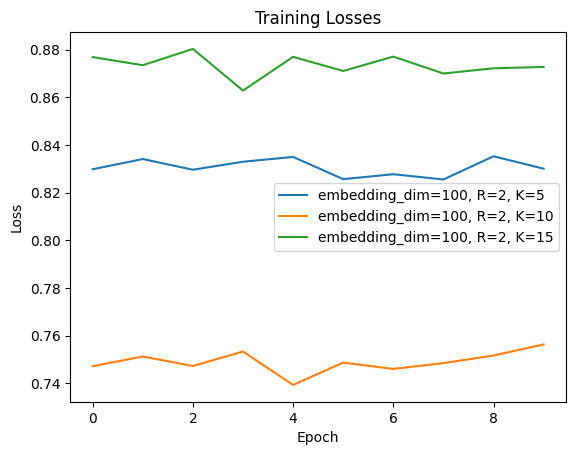

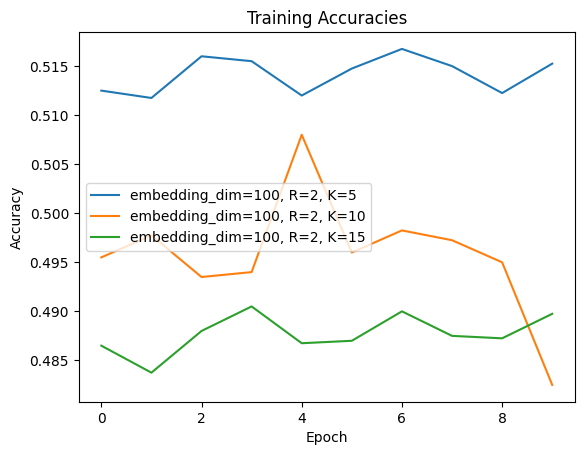

In [ ]:
run_ablation_study([100], [2], [5, 10, 15])

Ablation study for embedding_dim=100, R=2, K=10


Epoch 1/10:   0%|          | 0/25740 [00:00<?, ?it/s]

Epoch 1/10, Average Loss: 2.7611


Epoch 2/10:   0%|          | 0/25740 [00:00<?, ?it/s]

Epoch 2/10, Average Loss: 0.9553


Epoch 3/10:   0%|          | 0/25740 [00:00<?, ?it/s]

Epoch 3/10, Average Loss: 0.6680


Epoch 4/10:   0%|          | 0/25740 [00:00<?, ?it/s]

Epoch 4/10, Average Loss: 0.5392


Epoch 5/10:   0%|          | 0/25740 [00:00<?, ?it/s]

Epoch 5/10, Average Loss: 0.4639


Epoch 6/10:   0%|          | 0/25740 [00:00<?, ?it/s]

Epoch 6/10, Average Loss: 0.4150


Epoch 7/10:   0%|          | 0/25740 [00:00<?, ?it/s]

Epoch 7/10, Average Loss: 0.3813


Epoch 8/10:   0%|          | 0/25740 [00:00<?, ?it/s]

Epoch 8/10, Average Loss: 0.3579


Epoch 9/10:   0%|          | 0/25740 [00:00<?, ?it/s]

Epoch 9/10, Average Loss: 0.3413


Epoch 10/10:   0%|          | 0/25740 [00:00<?, ?it/s]

Epoch 10/10, Average Loss: 0.3291
Model saved to model_dim-100_radius-2_ratio-10_batch-32_epoch-10.ckpt
Ablation study for embedding_dim=100, R=4, K=10


Epoch 1/10:   0%|          | 0/25740 [00:00<?, ?it/s]

Epoch 1/10, Average Loss: 2.4275


Epoch 2/10:   0%|          | 0/25740 [00:00<?, ?it/s]

Epoch 2/10, Average Loss: 0.8670


Epoch 3/10:   0%|          | 0/25740 [00:00<?, ?it/s]

Epoch 3/10, Average Loss: 0.6339


Epoch 4/10:   0%|          | 0/25740 [00:00<?, ?it/s]

Epoch 4/10, Average Loss: 0.5298


Epoch 5/10:   0%|          | 0/25740 [00:00<?, ?it/s]

Epoch 5/10, Average Loss: 0.4726


Epoch 6/10:   0%|          | 0/25740 [00:00<?, ?it/s]

Epoch 6/10, Average Loss: 0.4373


Epoch 7/10:   0%|          | 0/25740 [00:00<?, ?it/s]

Epoch 7/10, Average Loss: 0.4137


Epoch 8/10:   0%|          | 0/25740 [00:00<?, ?it/s]

Epoch 8/10, Average Loss: 0.3971


Epoch 9/10:   0%|          | 0/25740 [00:00<?, ?it/s]

Epoch 9/10, Average Loss: 0.3850


Epoch 10/10:   0%|          | 0/25740 [00:00<?, ?it/s]

Epoch 10/10, Average Loss: 0.3761
Model saved to model_dim-100_radius-4_ratio-10_batch-32_epoch-10.ckpt
Ablation study for embedding_dim=100, R=6, K=10


Epoch 1/10:   0%|          | 0/25740 [00:00<?, ?it/s]

Epoch 1/10, Average Loss: 2.2454


Epoch 2/10:   0%|          | 0/25740 [00:00<?, ?it/s]

Epoch 2/10, Average Loss: 0.8104


Epoch 3/10:   0%|          | 0/25740 [00:00<?, ?it/s]

Epoch 3/10, Average Loss: 0.6038


Epoch 4/10:   0%|          | 0/25740 [00:00<?, ?it/s]

Epoch 4/10, Average Loss: 0.5152


Epoch 5/10:   0%|          | 0/25740 [00:00<?, ?it/s]

Epoch 5/10, Average Loss: 0.4692


Epoch 6/10:   0%|          | 0/25740 [00:00<?, ?it/s]

Epoch 6/10, Average Loss: 0.4413


Epoch 7/10:   0%|          | 0/25740 [00:00<?, ?it/s]

Epoch 7/10, Average Loss: 0.4234


Epoch 8/10:   0%|          | 0/25740 [00:00<?, ?it/s]

Epoch 8/10, Average Loss: 0.4108


Epoch 9/10:   0%|          | 0/25740 [00:00<?, ?it/s]

Epoch 9/10, Average Loss: 0.4015


Epoch 10/10:   0%|          | 0/25740 [00:00<?, ?it/s]

Epoch 10/10, Average Loss: 0.3947
Model saved to model_dim-100_radius-6_ratio-10_batch-32_epoch-10.ckpt


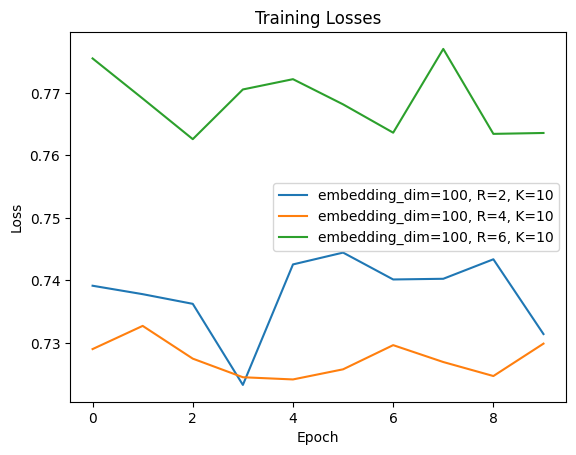

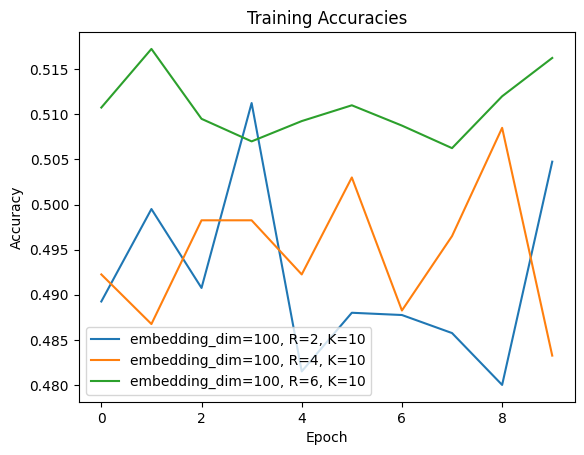

In [ ]:
run_ablation_study([100], [2, 4, 6], [10])

In [ ]:
run_ablation_study([50, 100, 200] , [2], [10])